## 라이브러리 import 및 초기 설정

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random


# TensorFlow 로그 레벨 설정 (INFO 메시지 숨김)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# 랜덤 시드 고정
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print("=== 🚀 EfficientNet-B0 전이학습 이진분류 ===")
print("ImageNet 사전학습 → 얼굴 표정 분류 전이학습")
print(f"TensorFlow 버전: {tf.__version__}")

=== 🚀 EfficientNet-B0 전이학습 이진분류 ===
ImageNet 사전학습 → 얼굴 표정 분류 전이학습
TensorFlow 버전: 2.20.0-dev20250425


In [5]:
# ========================================
# 셀 2: 데이터 로딩 함수 정의
# ========================================

def load_images_robust(folder_path, label, max_images=None):
    """더 강력한 이미지 로딩 함수"""
    from PIL import Image
    images = []
    labels = []
    failed_files = []
    
    if not os.path.exists(folder_path):
        print(f"❌ {folder_path} 폴더가 존재하지 않습니다.")
        return images, labels
    
    extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
    all_files = os.listdir(folder_path)
    image_files = [f for f in all_files if f.lower().endswith(extensions)]
    
    print(f"📁 {os.path.basename(folder_path)} 폴더:")
    print(f"   전체 파일: {len(all_files)}개")
    print(f"   이미지 파일: {len(image_files)}개")
    
    if max_images and len(image_files) > max_images:
        image_files = image_files[:max_images]
        print(f"   처리 대상: {len(image_files)}개 (제한됨)")
    
    for fname in tqdm(image_files, desc=f"Loading {os.path.basename(folder_path)}"):
        img_path = os.path.join(folder_path, fname)
        
        try:
            # 방법 1: OpenCV
            img = cv2.imread(img_path)
            
            if img is None:
                # 방법 2: PIL (한글 경로 문제 해결)
                pil_img = Image.open(img_path)
                img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
            
            if img is None or img.shape[0] == 0 or img.shape[1] == 0:
                failed_files.append(fname)
                continue
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            img = img.astype('float32') # [0,255] 유지
            
            images.append(img)
            labels.append(label)
            
        except Exception as e:
            failed_files.append(f"{fname}: {str(e)}")
            continue
    
    print(f"   ✅ 성공: {len(images)}개")
    print(f"   ❌ 실패: {len(failed_files)}개")
    
    if failed_files:
        print(f"   실패 파일들: {failed_files[:3]}...")
    
    return images, labels

In [6]:
# ========================================
# 셀 3: 데이터 경로 설정 및 로딩
# ========================================

# 데이터 경로 설정 (본인 경로에 맞게 수정하세요!)
base_path = r'D:\my_projects\calmman-facial-classification\data\processed'
teasing_path = os.path.join(base_path, 'teasing')
non_teasing_path = os.path.join(base_path, 'non_teasing')

print("=== 📁 데이터 로딩 ===")

# 비약올리기 이미지 로드 (라벨: 0)
X_non_teasing, y_non_teasing = load_images_robust(non_teasing_path, 0)

# 약올리기 이미지 로드 (라벨: 1)
X_teasing, y_teasing = load_images_robust(teasing_path, 1)

# 데이터 합치기
X = X_non_teasing + X_teasing
y = y_non_teasing + y_teasing

print(f"\n로딩 완료:")
print(f"  비약올리기: {len(X_non_teasing)}개")
print(f"  약올리기: {len(X_teasing)}개")
print(f"  총 이미지: {len(X)}개")

if len(X) == 0:
    print("❌ 로드된 이미지가 없습니다.")
    raise ValueError("데이터가 없습니다. 경로를 확인해주세요.")

=== 📁 데이터 로딩 ===
📁 non_teasing 폴더:
   전체 파일: 116개
   이미지 파일: 116개


Loading non_teasing: 100%|██████████| 116/116 [00:00<00:00, 802.83it/s]


   ✅ 성공: 116개
   ❌ 실패: 0개
📁 teasing 폴더:
   전체 파일: 80개
   이미지 파일: 80개


Loading teasing: 100%|██████████| 80/80 [00:00<00:00, 945.41it/s]

   ✅ 성공: 80개
   ❌ 실패: 0개

로딩 완료:
  비약올리기: 116개
  약올리기: 80개
  총 이미지: 196개


In [7]:
# ========================================
# 셀 4: 원본 데이터 분할 (데이터 누수 방지)
# ========================================

print("=== ✂️ 원본 데이터 분할 ===")

X_raw = np.array(X)
y_raw = np.array(y)

print(f"원본 데이터: {X_raw.shape}")
print(f"원본 클래스 분포: {np.bincount(y_raw)}")

# 원본 데이터를 먼저 분할
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=SEED, stratify=y_raw
)

print(f"원본 훈련 데이터: {X_train_raw.shape}")
print(f"원본 검증 데이터: {X_val_raw.shape}")
print(f"원본 훈련 클래스 분포: {np.bincount(y_train_raw)}")
print(f"원본 검증 클래스 분포: {np.bincount(y_val_raw)}")

=== ✂️ 원본 데이터 분할 ===
원본 데이터: (196, 224, 224, 3)
원본 클래스 분포: [116  80]
원본 훈련 데이터: (156, 224, 224, 3)
원본 검증 데이터: (40, 224, 224, 3)
원본 훈련 클래스 분포: [92 64]
원본 검증 클래스 분포: [24 16]


In [8]:
# ========================================
# 셀 5: 데이터 증강 함수 정의
# ========================================

def augment_data_efficientnet(X_array, y_array, target_per_class=250):
    """EfficientNet용 데이터 증강 함수"""
    
    class_0_indices = np.where(y_array == 0)[0]
    class_1_indices = np.where(y_array == 1)[0]
    
    class_0_data = [X_array[i] for i in class_0_indices]
    class_1_data = [X_array[i] for i in class_1_indices]
    
    print(f"=== 🔄 훈련 데이터 증강 ===")
    print(f"증강 전: 비약올리기 {len(class_0_data)}개, 약올리기 {len(class_1_data)}개")
    
    # 얼굴 표정에 적합한 증강 (보수적)
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.5),
        A.GaussNoise(var_limit=(10, 50), p=0.3),
    ])

    final_class_0 = class_0_data.copy()
    final_class_1 = class_1_data.copy()

    # 비약올리기 증강
    if len(class_0_data) < target_per_class:
        need_count = target_per_class - len(class_0_data)
        print(f"비약올리기 {need_count}개 증강 중...")
        
        for i in tqdm(range(need_count)):
            base_img = class_0_data[i % len(class_0_data)]
            # uint8로 변환 (Albumentations 요구사항)
            base_img_uint8 = (base_img * 255).astype(np.uint8)
            # 증강 적용
            augmented = transform(image=base_img_uint8)
            aug_img = augmented['image']
            # 다시 float32로 변환 [0,1] 범위
            aug_img = aug_img.astype(np.float32) / 255.0
            final_class_0.append(aug_img)

    # 약올리기 증강
    if len(class_1_data) < target_per_class:
        need_count = target_per_class - len(class_1_data)
        print(f"약올리기 {need_count}개 증강 중...")
        
        for i in tqdm(range(need_count)):
            base_img = class_1_data[i % len(class_1_data)]
            # uint8로 변환
            base_img_uint8 = (base_img * 255).astype(np.uint8)
            # 증강 적용
            augmented = transform(image=base_img_uint8)
            aug_img = augmented['image']
            # 다시 float32로 변환
            aug_img = aug_img.astype(np.float32) / 255.0
            final_class_1.append(aug_img)
    
    # 최종 데이터
    final_X = final_class_0 + final_class_1
    final_y = [0] * len(final_class_0) + [1] * len(final_class_1)
    
    print(f"증강 후: 비약올리기 {len(final_class_0)}개, 약올리기 {len(final_class_1)}개")
    print(f"총 훈련 데이터: {len(final_X)}개")
    
    return final_X, final_y

In [9]:
# ========================================
# 셀 6: 훈련 데이터 증강 실행
# ========================================

# 훈련 데이터만 증강 (검증 데이터는 원본 유지!)
X_train_aug, y_train_aug = augment_data_efficientnet(X_train_raw, y_train_raw, target_per_class=250)

# ========================================
# 셀 7: 최종 데이터 준비
# ========================================

print("=== 📦 최종 데이터 준비 ===")

# 훈련 데이터: 증강된 데이터 사용
X_train = np.array(X_train_aug)
y_train = np.array(y_train_aug)

# 검증 데이터: 원본 데이터 그대로 사용
X_val = X_val_raw
y_val = y_val_raw

print(f"최종 훈련 데이터: {X_train.shape}")
print(f"최종 검증 데이터: {X_val.shape}")
print(f"최종 훈련 클래스 분포: {np.bincount(y_train)}")
print(f"최종 검증 클래스 분포: {np.bincount(y_val)}")

print(f"✅ 데이터 누수 방지: 검증 데이터는 훈련 중 본 적 없는 원본 이미지만 사용")

C:\Users\pjjeo\AppData\Local\Temp\ipykernel_67580\1111987834.py:22: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.3),


=== 🔄 훈련 데이터 증강 ===
증강 전: 비약올리기 92개, 약올리기 64개
비약올리기 158개 증강 중...


100%|██████████| 158/158 [00:00<00:00, 1742.14it/s]


약올리기 186개 증강 중...


100%|██████████| 186/186 [00:00<00:00, 1797.17it/s]

증강 후: 비약올리기 250개, 약올리기 250개
총 훈련 데이터: 500개
=== 📦 최종 데이터 준비 ===
최종 훈련 데이터: (500, 224, 224, 3)
최종 검증 데이터: (40, 224, 224, 3)
최종 훈련 클래스 분포: [250 250]
최종 검증 클래스 분포: [24 16]
✅ 데이터 누수 방지: 검증 데이터는 훈련 중 본 적 없는 원본 이미지만 사용


In [10]:
# ========================================
# 셀 8: EfficientNet-B0 모델 구성 함수 정의
# ========================================

def create_efficientnet_model(input_shape=(224, 224, 3), num_classes=1):
    """EfficientNet-B0 기반 전이학습 모델 생성"""
    
    # 입력 레이어
    inputs = tf.keras.Input(shape=input_shape)
    
    # EfficientNet 전용 전처리 (ImageNet 정규화)
    x = preprocess_input(inputs)
    
    # EfficientNet-B0 백본 (사전학습된 가중치 사용, 분류 헤드 제외)
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_tensor=x
    )
    
    # 백본 동결
    base_model.trainable = False
    
    # 분류 헤드 구성
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)  # 보수적인 정규화
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # 이진분류
    
    model = tf.keras.Model(inputs, outputs)
    
    print(f"✅ EfficientNet-B0 백본 로드 완료")
    print(f"   - 백본 상태: 동결됨")
    print(f"   - 분류 헤드: GAP → Dropout(0.3) → Dense(1)")
    
    return model, base_model


In [12]:
# ========================================
# 셀 9: 모델 생성 및 구조 확인
# ========================================

print("=== 🏗️ EfficientNet-B0 전이학습 모델 구성 ===")

# 모델 생성
model, base_model = create_efficientnet_model()

# 모델 요약
print("\n모델 구조:")
# model.summary()


=== 🏗️ EfficientNet-B0 전이학습 모델 구성 ===
✅ EfficientNet-B0 백본 로드 완료
   - 백본 상태: 동결됨
   - 분류 헤드: GAP → Dropout(0.3) → Dense(1)

모델 구조:


In [15]:
# ========================================
# 셀 10: 클래스 가중치 설정 (옵션)
# ========================================

# 클래스 가중치 설정 (teasing 클래스에 더 높은 가중치)
# 기본값: {0: 1.0, 1: 1.0} (동일 가중치)
# 조정값: {0: 1.0, 1: 2.0} (teasing 클래스 2배 중요)

class_weight = {0: 1.0, 1: 2.0}  # 🔧 필요시 {0: 1.0, 1: 2.0}로 변경

print(f"클래스 가중치 설정: {class_weight}")
if class_weight[1] > 1.0:
    print(f"⚠️ teasing 클래스에 {class_weight[1]}배 가중치 적용")

클래스 가중치 설정: {0: 1.0, 1: 2.0}
⚠️ teasing 클래스에 2.0배 가중치 적용


In [16]:
# ========================================
# 셀 11: 1단계 학습 - 백본 동결 + 분류 헤드 학습
# ========================================

print("=== 🚀 1단계 학습: 백본 동결 + 분류 헤드 학습 ===")

# 1단계 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# 콜백 설정
callbacks_stage1 = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("1단계 학습 시작...")
print(f"  - 백본: 완전 동결")
print(f"  - 학습률: 0.001")
print(f"  - 목표: 분류 헤드 가중치 최적화")

=== 🚀 1단계 학습: 백본 동결 + 분류 헤드 학습 ===
1단계 학습 시작...
  - 백본: 완전 동결
  - 학습률: 0.001
  - 목표: 분류 헤드 가중치 최적화


In [17]:
# ========================================
# 셀 12: 1단계 학습 실행
# ========================================

# 1단계 학습 실행
history_stage1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_stage1,
    class_weight=class_weight,  # 클래스 가중치 적용
    verbose=1
)

# 1단계 결과
stage1_loss, stage1_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"\n1단계 완료:")
print(f"  - 검증 정확도: {stage1_acc:.4f}")
print(f"  - 검증 손실: {stage1_loss:.4f}")


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step - binary_accuracy: 0.4843 - loss: 1.0576 - val_binary_accuracy: 0.3000 - val_loss: 0.7539 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - binary_accuracy: 0.5477 - loss: 0.9442 - val_binary_accuracy: 0.4250 - val_loss: 0.7308 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - binary_accuracy: 0.5572 - loss: 0.9031 - val_binary_accuracy: 0.6250 - val_loss: 0.6612 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - binary_accuracy: 0.6014 - loss: 0.8962 - val_binary_accuracy: 0.6500 - val_loss: 0.6238 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - binary_accuracy: 0.6351 - loss: 0.8628 - val_binary_accuracy: 0.7000 - val_loss: 0.5957 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - binary_accuracy: 0.6308 - loss: 0.8506 - val_binary_accuracy: 0.7000 - val_loss: 0.5741 - learning_rate: 0.0010
Epoc

In [18]:
# ========================================
# 셀 13: 2단계 학습 - 백본 일부 해제 + 미세조정
# ========================================

print("=== 🔬 2단계 학습: 백본 일부 해제 + 미세조정 ===")

# 백본 일부 해제 (보수적으로 마지막 3개 레이어만)
base_model.trainable = True

# 마지막 3개 레이어만 학습 가능하게 설정
trainable_layers = 3
for layer in base_model.layers[:-trainable_layers]:
    layer.trainable = False

print(f"백본 레이어 해제:")
print(f"  - 전체 레이어: {len(base_model.layers)}개")
print(f"  - 해제 레이어: 마지막 {trainable_layers}개")
print(f"  - 동결 레이어: {len(base_model.layers) - trainable_layers}개")

# 2단계 컴파일 (더 작은 학습률)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 10배 작은 학습률
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# 콜백 설정 (더 보수적)
callbacks_stage2 = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

print("2단계 학습 시작...")
print(f"  - 백본: 마지막 {trainable_layers}개 레이어 해제")
print(f"  - 학습률: 0.0001 (10배 감소)")
print(f"  - 목표: 얼굴 표정에 특화된 미세조정")

=== 🔬 2단계 학습: 백본 일부 해제 + 미세조정 ===
백본 레이어 해제:
  - 전체 레이어: 238개
  - 해제 레이어: 마지막 3개
  - 동결 레이어: 235개
2단계 학습 시작...
  - 백본: 마지막 3개 레이어 해제
  - 학습률: 0.0001 (10배 감소)
  - 목표: 얼굴 표정에 특화된 미세조정


In [19]:
# ========================================
# 셀 14: 2단계 학습 실행
# ========================================

# 2단계 학습 실행
history_stage2 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_stage2,
    class_weight=class_weight,  # 클래스 가중치 적용
    verbose=1
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 400ms/step - binary_accuracy: 0.6685 - loss: 0.7618 - val_binary_accuracy: 0.8250 - val_loss: 0.4695 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - binary_accuracy: 0.6753 - loss: 0.7091 - val_binary_accuracy: 0.8250 - val_loss: 0.4582 - learning_rate: 1.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - binary_accuracy: 0.6701 - loss: 0.7075 - val_binary_accuracy: 0.8250 - val_loss: 0.4518 - learning_rate: 1.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - binary_accuracy: 0.6765 - loss: 0.7138 - val_binary_accuracy: 0.8250 - val_loss: 0.4582 - learning_rate: 1.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - binary_accuracy: 0.6839 - loss: 0.6948 - val_binary_accuracy: 0.8250 - val_loss: 0.4665 - learning_rate: 1.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - binary_accuracy: 0.6738 - loss: 0.7239
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9

In [20]:
# ========================================
# 셀 15: 최종 성능 평가
# ========================================

print("=== 📊 최종 성능 평가 ===")

# 최종 평가
final_loss, final_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"최종 검증 정확도: {final_accuracy:.4f}")
print(f"최종 검증 손실: {final_loss:.4f}")

# 예측 수행
y_pred_prob = model.predict(X_val, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# 분류 보고서
classes = ['non_teasing', 'teasing']
print(f"\n분류 보고서:")
print(classification_report(y_val, y_pred, target_names=classes))

# F1 Score 계산
f1 = f1_score(y_val, y_pred)
print(f"\nF1 Score: {f1:.4f}")

# 혼동 행렬
print(f"\n혼동 행렬:")
cm = confusion_matrix(y_val, y_pred)
print(cm)

# 예측 분포 확인
print(f"\n예측 분포:")
print(f"예측 확률 범위: {y_pred_prob.min():.4f} ~ {y_pred_prob.max():.4f}")
print(f"예측 확률 표준편차: {y_pred_prob.std():.4f}")
print(f"예측 클래스 분포: {np.bincount(y_pred)}")

=== 📊 최종 성능 평가 ===
최종 검증 정확도: 0.8250
최종 검증 손실: 0.4518

분류 보고서:
              precision    recall  f1-score   support

 non_teasing       0.79      0.96      0.87        24
     teasing       0.91      0.62      0.74        16

    accuracy                           0.82        40
   macro avg       0.85      0.79      0.80        40
weighted avg       0.84      0.82      0.82        40


F1 Score: 0.7407

혼동 행렬:
[[23  1]
 [ 6 10]]

예측 분포:
예측 확률 범위: 0.0139 ~ 0.9946
예측 확률 표준편차: 0.3219
예측 클래스 분포: [29 11]


=== 📈 결과 시각화 ===


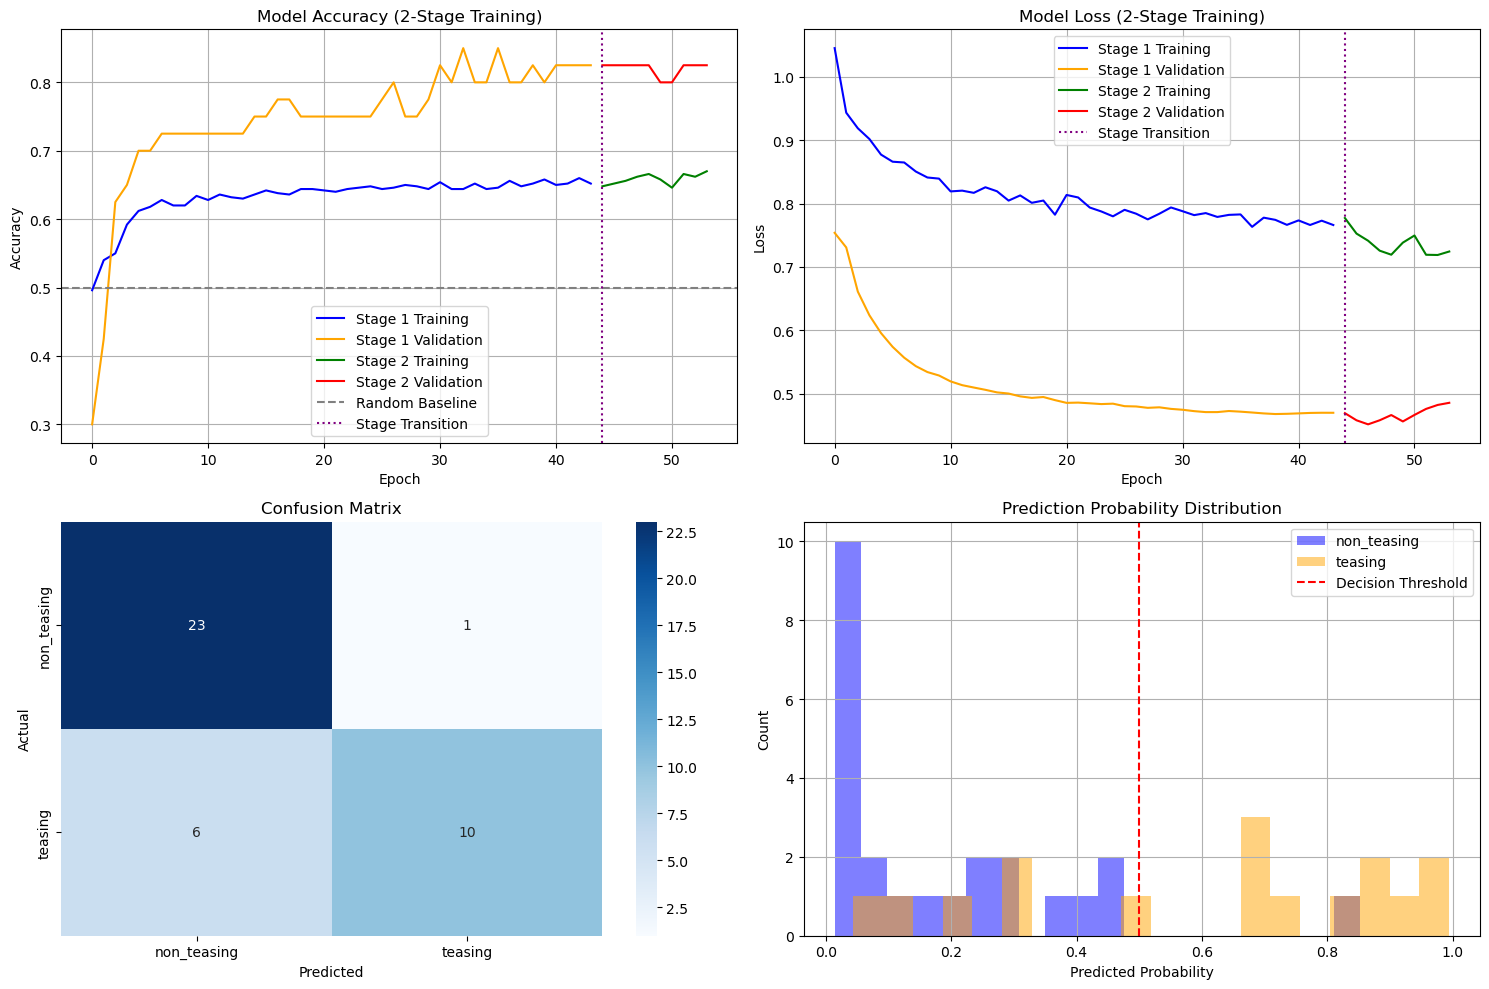

In [21]:
# ========================================
# 셀 16: 결과 시각화
# ========================================

print("=== 📈 결과 시각화 ===")

# 두 단계 학습 과정 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1단계 정확도
axes[0,0].plot(history_stage1.history['binary_accuracy'], label='Stage 1 Training', color='blue')
axes[0,0].plot(history_stage1.history['val_binary_accuracy'], label='Stage 1 Validation', color='orange')
if 'binary_accuracy' in history_stage2.history:
    stage1_epochs = len(history_stage1.history['binary_accuracy'])
    stage2_epochs = range(stage1_epochs, stage1_epochs + len(history_stage2.history['binary_accuracy']))
    axes[0,0].plot(stage2_epochs, history_stage2.history['binary_accuracy'], label='Stage 2 Training', color='green')
    axes[0,0].plot(stage2_epochs, history_stage2.history['val_binary_accuracy'], label='Stage 2 Validation', color='red')
axes[0,0].axhline(y=0.5, color='gray', linestyle='--', label='Random Baseline')
axes[0,0].axvline(x=len(history_stage1.history['binary_accuracy']), color='purple', linestyle=':', label='Stage Transition')
axes[0,0].set_title('Model Accuracy (2-Stage Training)')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True)

# 1단계 손실
axes[0,1].plot(history_stage1.history['loss'], label='Stage 1 Training', color='blue')
axes[0,1].plot(history_stage1.history['val_loss'], label='Stage 1 Validation', color='orange')
if 'loss' in history_stage2.history:
    stage1_epochs = len(history_stage1.history['loss'])
    stage2_epochs = range(stage1_epochs, stage1_epochs + len(history_stage2.history['loss']))
    axes[0,1].plot(stage2_epochs, history_stage2.history['loss'], label='Stage 2 Training', color='green')
    axes[0,1].plot(stage2_epochs, history_stage2.history['val_loss'], label='Stage 2 Validation', color='red')
axes[0,1].axvline(x=len(history_stage1.history['loss']), color='purple', linestyle=':', label='Stage Transition')
axes[0,1].set_title('Model Loss (2-Stage Training)')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

# 혼동 행렬 히트맵
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=classes, yticklabels=classes, ax=axes[1,0])
axes[1,0].set_title('Confusion Matrix')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')

# 예측 확률 분포
axes[1,1].hist(y_pred_prob[y_val==0], alpha=0.5, label='non_teasing', bins=20, color='blue')
axes[1,1].hist(y_pred_prob[y_val==1], alpha=0.5, label='teasing', bins=20, color='orange')
axes[1,1].axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
axes[1,1].set_title('Prediction Probability Distribution')
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_ylabel('Count')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

In [22]:
# ========================================
# 셀 17: 성능 개선 분석 및 결론
# ========================================

print("=== 🎯 성능 개선 분석 ===")

baseline_accuracy = 0.775  # 기본 CNN 성능
improvement = final_accuracy - baseline_accuracy
improvement_percent = (improvement / baseline_accuracy) * 100

print(f"✅ EfficientNet-B0 전이학습 결과:")
print(f"   - 기본 CNN: 77.5%")
print(f"   - EfficientNet: {final_accuracy:.1%}")
print(f"   - 개선폭: {improvement:+.1%} ({improvement_percent:+.1f}%)")
print(f"   - F1 Score: {f1:.4f}")
print(f"   - 총 학습 에포크: {len(history_stage1.history['loss']) + len(history_stage2.history['loss'])}회")

if final_accuracy > 0.82:
    print(f"🎉 목표 달성! 전이학습이 매우 효과적")
elif final_accuracy > 0.80:
    print(f"👍 목표 근접! 전이학습 효과 확인")
elif final_accuracy > baseline_accuracy:
    print(f"✨ 성능 향상! 전이학습 도움됨")
else:
    print(f"🤔 성능 정체. 추가 조정 필요")

print(f"\n💡 다음 단계 제안:")
if final_accuracy < 0.80:
    print(f"   - 데이터 수집 확대")
    print(f"   - VGGFace2 사전학습 모델 시도")
    print(f"   - 하이퍼파라미터 튜닝")
else:
    print(f"   - 모델 앙상블 시도")
    print(f"   - 테스트 데이터로 최종 검증")
    print(f"   - 실제 서비스 적용 고려")

print(f"\n🚀 EfficientNet-B0 전이학습 완료!")

=== 🎯 성능 개선 분석 ===
✅ EfficientNet-B0 전이학습 결과:
   - 기본 CNN: 77.5%
   - EfficientNet: 82.5%
   - 개선폭: +5.0% (+6.5%)
   - F1 Score: 0.7407
   - 총 학습 에포크: 54회
🎉 목표 달성! 전이학습이 매우 효과적

💡 다음 단계 제안:
   - 모델 앙상블 시도
   - 테스트 데이터로 최종 검증
   - 실제 서비스 적용 고려

🚀 EfficientNet-B0 전이학습 완료!


In [23]:
# ========================================
# 셀 18: 모델 저장 (선택사항)
# ========================================

# 훈련된 모델 저장
model_save_path = 'efficientnet_teasing_classifier.h5'
model.save(model_save_path)
print(f"💾 모델 저장 완료: {model_save_path}")

# 나중에 로드할 때:
# loaded_model = tf.keras.models.load_model(model_save_path)

💾 모델 저장 완료: efficientnet_teasing_classifier.h5


In [4]:

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# Windows 환경에서 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False
print("한글 폰트 설정 완료 (맑은 고딕)")

한글 폰트 설정 완료 (맑은 고딕)


In [5]:
# ========================================
# 셀 19: 테스트 이미지 시각화 함수 정의
# ========================================

import math
from PIL import Image

def test_images_visualization(test_dir, model, img_size=224):
    """테스트 디렉토리의 모든 이미지를 분류하고 시각화"""
    
    # 이미지 파일 목록 가져오기
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
    
    if not os.path.exists(test_dir):
        print(f"❌ 테스트 디렉토리가 존재하지 않습니다: {test_dir}")
        return None
    
    image_files = [f for f in os.listdir(test_dir) 
                   if f.lower().endswith(image_extensions)]
    
    if not image_files:
        print("❌ 테스트 이미지가 없습니다!")
        return None
    
    print(f"📁 총 {len(image_files)}개의 테스트 이미지를 발견했습니다.")
    
    # 이미지 로드 및 전처리
    images = []
    filenames = []
    
    for filename in tqdm(image_files, desc="이미지 로딩"):
        img_path = os.path.join(test_dir, filename)
        
        try:
            # 이미지 로드
            img = cv2.imread(img_path)
            if img is None:
                # PIL로 재시도 (한글 경로 문제 해결)
                pil_img = Image.open(img_path)
                img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
            
            if img is None or img.shape[0] == 0 or img.shape[1] == 0:
                print(f"⚠️ 이미지 로드 실패: {filename}")
                continue
            
            # BGR to RGB 변환
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # 크기 조정 및 정규화 (훈련 데이터와 동일한 전처리)
            img_resized = cv2.resize(img_rgb, (img_size, img_size))
            img_normalized = img_resized.astype('float32')  # [0,255] 유지 (EfficientNet 전처리에서 처리)
            
            images.append(img_normalized)
            filenames.append(filename)
            
        except Exception as e:
            print(f"❌ 이미지 로드 실패 - {filename}: {str(e)}")
            continue
    
    if not images:
        print("❌ 로드 가능한 이미지가 없습니다!")
        return None
    
    print(f"✅ {len(images)}개 이미지 로드 완료")
    
    # 배치로 예측
    images_array = np.array(images)
    print("🔮 예측 중...")
    predictions = model.predict(images_array, verbose=0)
    
    # 결과 분석
    teasing_count = 0
    non_teasing_count = 0
    results = []
    
    for i, (pred_prob, filename) in enumerate(zip(predictions, filenames)):
        prob = pred_prob[0]
        pred_class = "약올리기" if prob > 0.5 else "비약올리기"
        confidence = prob if prob > 0.5 else 1 - prob
        
        if pred_class == "약올리기":
            teasing_count += 1
        else:
            non_teasing_count += 1
        
        results.append({
            'image': images[i] / 255.0,  # 시각화용으로 [0,1] 범위로 변환
            'filename': filename,
            'prediction': pred_class,
            'probability': prob,
            'confidence': confidence
        })
    
    # 결과 요약 출력
    print(f"\n=== 🎯 분류 결과 요약 ===")
    print(f"약올리기: {teasing_count}개")
    print(f"비약올리기: {non_teasing_count}개")
    print(f"비율 - 약올리기:{teasing_count} vs 비약올리기:{non_teasing_count}")
    
    return results

def visualize_test_results(results):
    """테스트 결과를 시각화"""
    if not results:
        print("❌ 시각화할 결과가 없습니다!")
        return
    
    n_images = len(results)
    cols = 4  # 한 행에 4개씩
    rows = math.ceil(n_images / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    
    # axes가 1차원인 경우 2차원으로 변환
    if n_images == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i, result in enumerate(results):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        
        # 이미지 표시
        ax.imshow(result['image'])
        
        # 제목 설정 (예측 결과 + 확신도)
        color = 'red' if result['prediction'] == '약올리기' else 'blue'
        title = f"{result['prediction']}\n확신도: {result['confidence']:.2f}\n{result['filename']}"
        ax.set_title(title, fontsize=10, color=color, weight='bold')
        ax.axis('off')
    
    # 빈 서브플롯 숨기기
    for i in range(n_images, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    
    # 요약 정보
    teasing_count = sum(1 for r in results if r['prediction'] == '약올리기')
    non_teasing_count = len(results) - teasing_count
    
    plt.suptitle(f'🎯 테스트 이미지 분류 결과 (약올리기:{teasing_count} vs 비약올리기:{non_teasing_count})', 
                 fontsize=16, y=1.02)
    plt.show()

print("✅ 테스트 이미지 시각화 함수 정의 완료")




✅ 테스트 이미지 시각화 함수 정의 완료


In [10]:

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

model_save_path = 'efficientnet_teasing_classifier.h5'
loaded_model = tf.keras.models.load_model(model_save_path)
model=loaded_model


=== 🧪 테스트 이미지 분류 시작 ===
테스트 디렉토리: ../data/processed/test_image
📁 총 8개의 테스트 이미지를 발견했습니다.


이미지 로딩: 100%|██████████| 8/8 [00:00<00:00, 129.63it/s]

✅ 8개 이미지 로드 완료
🔮 예측 중...



=== 🎯 분류 결과 요약 ===
약올리기: 4개
비약올리기: 4개
비율 - 약올리기:4 vs 비약올리기:4


c:\Users\pjjeo\anaconda3\envs\pytorch-cuda124\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


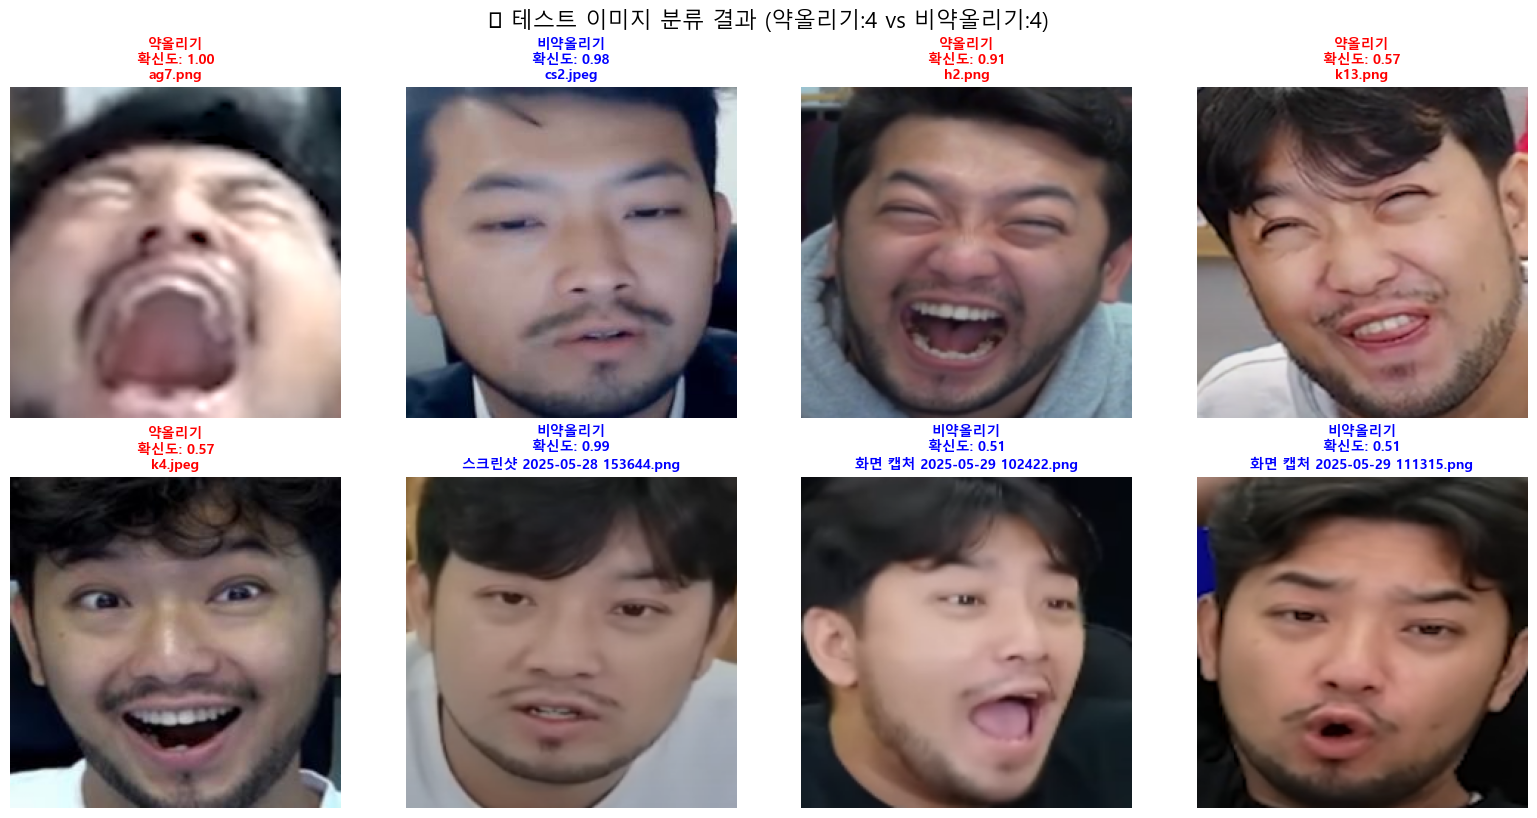


=== 📋 상세 결과 ===
 1. ag7.png              → 약올리기   (확률: 0.998)
 2. cs2.jpeg             → 비약올리기  (확률: 0.015)
 3. h2.png               → 약올리기   (확률: 0.910)
 4. k13.png              → 약올리기   (확률: 0.574)
 5. k4.jpeg              → 약올리기   (확률: 0.567)
 6. 스크린샷 2025-05-28 153644.png → 비약올리기  (확률: 0.014)
 7. 화면 캡처 2025-05-29 102422.png → 비약올리기  (확률: 0.494)
 8. 화면 캡처 2025-05-29 111315.png → 비약올리기  (확률: 0.494)


In [11]:
# ========================================
# 셀 20: 테스트 이미지 분류 실행
# ========================================

# 테스트 디렉토리 경로 설정 (상대경로 사용)
test_dir = r'../data/processed/test_image'

# 절대경로로도 설정 가능
# test_dir = r'D:\my_projects\calmman-facial-classification\data\processed\test_image'

print("=== 🧪 테스트 이미지 분류 시작 ===")
print(f"테스트 디렉토리: {test_dir}")

# 테스트 실행
results = test_images_visualization(test_dir, model)

# 결과 시각화
if results:
    visualize_test_results(results)
    
    # 상세 결과 출력
    print(f"\n=== 📋 상세 결과 ===")
    for i, result in enumerate(results, 1):
        print(f"{i:2d}. {result['filename']:20s} → {result['prediction']:6s} (확률: {result['probability']:.3f})")
else:
    print("❌ 테스트를 수행할 수 없습니다.")